In [ ]:
# Useful Links
# 1. https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# 2. https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/
# 3. https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0 (Understanding the resnet architecture for cifar10)


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [2]:
# Load necessary libraries
import os
import pandas as pd
import numpy as np
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
#from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model




In [3]:
def load_dataset(dName="CIFAR10"):
    dataset = None
    num_classes = None
    if dName == "CIFAR10":
        num_classes = 10
        dataset = tf.keras.datasets.cifar10.load_data()
    if dName == "CIFAR100":
        num_classes = 100
        dataset = tf.keras.datasets.cifar100.load_data()
    (X_train, y_train), (X_test, y_test) = dataset
    # Convert target value to categorical values
    # One-hot-encoded target values
    y_train = to_categorical(y_train,num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    return (X_train, y_train),(X_test, y_test)

In [4]:
def divideDataset(X_train, y_train, X_test,y_test):
    dataLength = X_train.shape[0]
    trainLen=0
    dataTrain = []
    dataTest = []
    percent = 0.2
    while(trainLen<dataLength):
        trainLen = int(X_train.shape[0]*percent)
        print(X_train[:trainLen].shape)
        train = (X_train[:trainLen],y_train[:trainLen])
        retriveLen = int(X_test.shape[0]*percent)
        test = (X_test[:retriveLen],y_test[:retriveLen])
        #print(tuple(train))
        dataTrain.append(train)
        dataTest.append(test)
        print("\n")
        percent +=0.2
    return dataTrain, dataTest

In [6]:
(X_train, y_train),(X_test, y_test) = load_dataset()
dataTrain, dataTest = divideDataset(X_train, y_train, X_test, y_test) # this contains the list of 5 different datasets

(10000, 32, 32, 3)


(20000, 32, 32, 3)


(30000, 32, 32, 3)


(40000, 32, 32, 3)


(50000, 32, 32, 3)




In [7]:
def describeDataset(X_train, y_train, X_test, y_test):
    print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

In [8]:
def displayImage(images=None):
    if images.any():
        # Plot a few images
        for i in range(9):
            plt.subplot(330+1+i)
            plt.imshow(images[i])
        plt.show()
    else:
        print('Error! File is empty')

In [9]:
def normalizeInput(X_train,X_test):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    mean = np.mean(X_train, axis=(0,1,2,3))
    std = np.std(X_train,axis=(0,1,2,3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    
    return X_train, X_test

In [ ]:
# plot diagnostic learning curves
def plotLearningCurve(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

In [10]:
(X_train, y_train),(X_test, y_test) = load_dataset()
describeDataset(X_train,y_train,X_test,y_test)

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


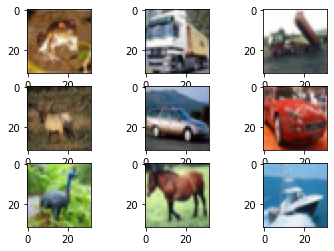

In [11]:
displayImage(X_train) # Need to pass a numpy array

In [ ]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(X_train, y_train, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(X_test, y_test, batch_size=batch_size) # so as valid_lab

In [ ]:
X_train, X_test = normalizeInput(dataTrain[0][0], dataTest[0][0])
y_train = dataTrain[0][1]
y_test = dataTest[0][1]

In [ ]:
# define cnn model
def defineModel():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
#model = defineModel()
#history = model.fit(X_train,y_train,epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2)

In [ ]:
#plotLearningCurve(history)

# ResNet Implementation

In [ ]:
# Code Link: https://github.com/Gurupradeep/CIFAR-10-Object-Recognition-in-Images/blob/master/Models/ResNet.ipynb

In [12]:
"""
Initial Convolutional layer which is common to all ResNet models.
"""
#Input : Input tensor
#filter : No of Convolutional filters
#stride : stride length 
#kernel_size : Convolutional filter size

#NOTE : kernel size and stride length are 7 and 2 in resnet paper

# Kernel size of 3 and stride length of 2 and 1 are tried for CIFAR-10 dataset because of low resolution of the images

def initial_conv(Input, filters, stride = 1,kernel_size = 7):
    
    x = Conv2D(filters, kernel_size=(kernel_size,kernel_size), strides = (stride,stride), padding = "same")(Input)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    return x

In [ ]:
"""
Residual Block with projection shortcut to match the dimensions using 1*1 convolutions.

Note : This is basic residual Block, here all the convolutions are of same size and the depth is kept constant

"""

# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Note : Stride 2 is used to downsample the image in CONV2,CONV3 and CONV4 blocks
# Dropout : Adds Dropout layer if dropout is greater than 0

def expand_conv_basic_block(Input, filters, stride=1, dropout = 0.0):
    Init = Input
    
    #First conv which is used to downsample the image
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Optional Dropout layer
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Projection shortcut to make skip connection(Paper terminology)
    skip_conv = Conv2D(filters, kernel_size = (1,1),strides = (stride,stride),padding = "same")(Input)
    skip = BatchNormalization()(skip_conv)
    
    #Skip connection
    x = Add()([x,skip])
    return x

In [ ]:
"""
Residual networks with basic Identity shortcuts

"""
# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Dropout : Adds Dropout layer if dropout is greater than 0

def normal_conv_basic_block(Input, filters, stride = 1, dropout = 0.0):
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Optional Dropout layer
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Identity skip connection
    x = Add()([x,Input])
    
    return x

In [ ]:
"""
Residual Block with projection shortcut to match the dimensions using 1*1 convolutions.

Note : This is bottleneck residual block. Here first 1*1 convolution is used to reduce depth, followed by 3*3 
        and last 1*1 is used to restore the depth

"""

# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Note : Stride 2 is used to downsample the image in CONV2,CONV3 and CONV4 blocks
# Dropout : Adds Dropout layer if dropout is greater than 0

def expand_conv_bottleneck_block(Input,filters,stride=1,dropout = 0.0):
    
    #Contracting 1*1 conv
    x = Conv2D(filters,kernel_size=(1,1),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(dropout > 0.0):
     #   x = Dropout(dropout)(x)
    
    #Depth preserving 3*3 conv
    x = Conv2D(filters,kernel_size=(3,3),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(Dropout > 0.0):
     #   x = Dropout(dropout)(x)
    
    #Expanding 1*1 Conv
    x = Conv2D(filters*4,kernel_size=(1,1),strides = (1,1),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Projection shortcut
    skip_conv = Conv2D(filters*4,kernel_size = (1,1), strides = (stride, stride),padding = "same")(Input)
    skip = BatchNormalization()(skip_conv)
    
    #Skip connection
    x = Add()([x,skip])
    
    return x

In [ ]:
"""
Residual networks with bottleneck Identity shortcuts

"""
# Input : Input tensor
# filters : No of Filters
# Stride : stride length 
# Dropout : Adds Dropout layer if dropout is greater than 0


def normal_conv_bottleneck_block(Input, filters, stride = 1, dropout = 0.0):
    #Contracting 1*1 conv
    x = Conv2D(filters,kernel_size=(1,1),strides = (stride,stride),padding = "same")(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #if(dropout > 0.0):
     #   x = Dropout(dropout)(x)
        
    #Depth preserving 3*3 Conv
    x = Conv2D(filters,kernel_size=(3,3),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
   # if(Dropout > 0.0):
    #    x = Dropout(dropout)(x)
    
    #Expanding 1*1 Conv
    x = Conv2D(filters*4,kernel_size=(1,1),strides = (stride,stride),padding = "same")(x)
    x = BatchNormalization()(x)
    
    #Identity skip connection
    x = Add()([x,Input])
    
    return x

In [ ]:
"""
Helper function to Build ResNet using basic residual blocks.
Used when the total no of layers are less than 50.

"""
#h = height of the image
#w = width of the image
#no_of_outputs = no of classification classes
#r1 = No of times first conv block should be repeated
#r2 = No of times second conv block should be repeated
#r3 = No of times third conv block should be repeated
#r4 = No of times fourth conv block should be repeated

# first_conv_stride = stride which will be used for initial conv block
# first_max_pool = boolean to decide to apply max pooling or not
# first_conv_size = kernel size which will be used for initial conv block

#NOTE : The above three parameters are used only for cifar 10 data set coz of it's low resolution. 
        #For ImageNet Dataset they can be left as default


def build_basic_resnet(h, w, no_of_outputs, r1,r2,r3,r4, first_conv_stride = 2, first_max_pool = True,first_conv_kernel_size = 7):
    
    #Creating input tensor
    inputs = Input(shape = (h,w,3), name = "image_input")
    
    # Inital Conv block
    x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
    
    #Optional Max pooling layer
    if(first_max_pool):
        x = MaxPooling2D(pool_size=(2,2))(x)
    

    #Expanding block1 with projection shortcut
    x = expand_conv_basic_block(x,64,1)
    x = Activation('relu')(x)
    
    #Repeating block of Conv1
    for i in range(r1-1):
        x = normal_conv_basic_block(x,64)
        x = Activation('relu')(x)
    
    #Expanding block2 with projection shortcut
    x = expand_conv_basic_block(x,128,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv2
    for i in range(r2-1):
        x = normal_conv_basic_block(x,128)
        x = Activation('relu')(x)
    
    #Expanding block3 with projection shortcut
    x = expand_conv_basic_block(x,256,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r3-1):
        x = normal_conv_basic_block(x,256)
        x = Activation('relu')(x)
          
     #Expanding block4 with projection shortcut
    x = expand_conv_basic_block(x,512,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r4-1):
        x = normal_conv_basic_block(x,512)
        x = Activation('relu')(x)
    
    shape = K.int_shape(x)
    
    #Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                                 strides=(1, 1))(x)
   # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    #Classifier Block
    x = Dense(no_of_outputs,activation='softmax')(x)
    
    model = Model(inputs = inputs, outputs = x)
    return model

In [ ]:
"""
Helper function to Build ResNet using bottleneck residual blocks.
Used when the total no of layers are more than 50.

"""
#h = height of the image
#w = width of the image
#no_of_outputs = no of classification classes
#r1 = No of times first conv block should be repeated
#r2 = No of times second conv block should be repeated
#r3 = No of times third conv block should be repeated
#r4 = No of times fourth conv block should be repeated

# first_conv_stride = stride which will be used for initial conv block
# first_max_pool = boolean to decide to apply max pooling or not
# first_conv_size = kernel size which will be used for initial conv block

#NOTE : The above three parameters are used only for cifar 10 data set coz of it's low resolution. 
        #For ImageNet Dataset they can be left as default


def build_bottleneck_resnet(h, w, no_of_outputs, r1,r2,r3,r4, first_conv_stride = 2, first_max_pool = True,first_conv_kernel_size = 7):
    
    #Creating input tensor
    inputs = Input(shape = (h,w,3), name = "image_input")
    
    # Inital Conv block
    x = initial_conv(inputs,64,first_conv_stride,first_conv_kernel_size)
    
    #Optional Max pooling layer
    if(first_max_pool):
        x = MaxPooling2D(pool_size=(2,2))(x)
        
    #Expanding block1 with projection shortcut
    x = expand_conv_bottleneck_block(x,64,1)
    x = Activation('relu')(x)
    
    #Repeating block of Conv1
    for i in range(r1-1):
        x = normal_conv_bottleneck_block(x,64)
        x = Activation('relu')(x)
    
    #Expanding block2 with projection shortcut
    x = expand_conv_bottleneck_block(x,128,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv2
    for i in range(r2-1):
        x = normal_conv_bottleneck_block(x,128)
        x = Activation('relu')(x)
    
    #Expanding block3 with projection shortcut
    x = expand_conv_bottleneck_block(x,256,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv3
    for i in range(r3-1):
        x = normal_conv_bottleneck_block(x,256)
        x = Activation('relu')(x)
    
    #Expanding block4 with projection shortcut
    x = expand_conv_bottleneck_block(x,512,2)
    x = Activation('relu')(x)
    
    #Repeating block of Conv4
    for i in range(r4-1):
        x = normal_conv_bottleneck_block(x,512)
        x = Activation('relu')(x)
    
    shape = K.int_shape(x)
    
    #Average pooling layer
    x = AveragePooling2D(pool_size=(shape[1], shape[2]),
                                 strides=(1, 1))(x)
   # x = GlobalAveragePooling2D()(x)

    #Classifier Block
    x = Flatten()(x)
    x = Dense(no_of_outputs,activation='softmax')(x)
    
    model = Model(inputs = inputs, outputs = x)
    return model

In [ ]:

#ResNet50 with stride 1 in Initial conv Block
model = build_bottleneck_resnet(32,32,10,3,4,6,3,1,True,7)

In [ ]:
model.summary()

In [ ]:

model.compile(loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy'])

In [ ]:
plot_model(model,"ResNet50_without_maxpool_and_stride1.png",show_shapes=True)


In [ ]:
#Defining Callback functions which will be called by model during runtime when specified condition satisfies

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)
csv_logger = CSVLogger('ResNet50_without_dropout_without_conv_without_pool0.csv')
early_stopper = EarlyStopping(min_delta=0.001, patience=30)
model_chekpoint = ModelCheckpoint("ResNet50_without_dropout_without_conv_without_pool.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [ ]:
#model Parameters
batch_size = 64
data_augmentation = False
epochs = 30

In [ ]:
if data_augmentation :
    print("-------------Using Data augmentation------------")
     # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
    datagen.fit(X_train)
    model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,verbose=1,validation_data=(X_test,y_test),callbacks = [lr_reducer,csv_logger])
    
else :
    print("-----Not Using Data augmentation---------------")
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,callbacks = [csv_logger])

# RESNET50 WITH SKIP CONNECTION 2: Implemented by Lokesh

In [113]:
def createStageOne(x, filters,kernels, strides,paddings,counter):
  '''
  Argument
  x - input
  f - filter_size
  k - kernel size
  s - stride
  p - padding
  '''
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_1'+counter
  x_skip = x
  x = Conv2D(f1, kernel_size=(k1,k1),strides=(s1,s1),padding=p1, name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)

  x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  #print("Stage 1:", x.shape)

  return x


In [114]:
def createStageTwo(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  #print("stage 2", x.shape)
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_2'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  #print('Stage 2:',x.shape)
  return x

In [135]:
def createStageThree(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  print("stage 3", x.shape)
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_3'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  #print('Stage 3:',x.shape)
  return x

In [134]:
def createStageFour(x,filters,kernels,strides,paddings,counter):
  '''
  Arguments
  x - input
  filters - filter size
  kernels - kernel size
  strides - stride size
  paddings - padding size
  '''
  print("stage 3", x.shape)
  f1, f2 = filters
  k1, k2 = kernels
  s1, s2 = strides
  p1, p2 = paddings
  block_name = 'stage_4'+counter
  x_skip = x
  x = Conv2D(f1,kernel_size=(k1,k1),strides=(s1,s1),padding=p1,name=block_name+'a')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(f2,kernel_size=(k2,k2),strides=(s2,s2),padding=p2,name=block_name+'b')(x)
  x = BatchNormalization()(x)
  if x.shape[1] != x_skip.shape[1]:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(2,2),padding='valid')(x_skip)
  else:
    x_skip = Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)
  x = Add()([x,x_skip])
  x = Activation('relu')(x)
  print('Stage 4:',x.shape)
  return x

In [144]:
def resnet50():
  inputs = Input(shape = (32,32,3), name = "image_input")
  x = ZeroPadding2D((3,3))(inputs)
  # Initial Convolutional block
  
  x = Conv2D(64, kernel_size=(7,7), strides = (2,2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  print("before Max pooling: ", x.shape)
  x = MaxPooling2D((3,3),strides=(2,2))(x)
  x = createStageOne(x,[64,64],[1,3],[1,1],['valid','same'],'1')
  x = createStageOne(x,[256,64],[1,1],[1,1],['valid','valid'],'2')
  x = createStageOne(x,[64,256],[3,1],[1,1],['same','valid'],'3')
  x = createStageOne(x,[64,64],[1,3],[1,1],['valid','same'],'4')
  x = createStageTwo(x,[256,128],[1,1],[1,2],['valid','valid'],'5')
  x = createStageTwo(x,[128,512],[3,1],[1,1],['same','valid'],'6')
  x = createStageTwo(x,[128,128],[1,3],[1,1],['valid','same'],'7')
  x = createStageTwo(x,[512,128],[1,1],[1,1],['valid','valid'],'8')
  x = createStageTwo(x,[128,512],[3,1],[1,1],['same','valid'],'9')
  x = createStageTwo(x,[128,128],[1,3],[1,1],['valid','same'],'10')
  x = createStageThree(x,[512,256],[1,1],[1,2],['valid','valid'],'11')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'12')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'13')
  x = createStageThree(x,[1024,256],[1,1],[1,1],['valid','valid'],'14')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'15')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'16')
  x = createStageThree(x,[1024,256],[1,1],[1,1],['valid','valid'],'17')
  x = createStageThree(x,[256,1024],[3,1],[1,1],['same','valid'],'18')
  x = createStageThree(x,[256,256],[1,3],[1,1],['valid','same'],'19')
  x = createStageFour(x,[1024,512],[1,1],[1,2],['valid','valid'],'20')
  x = createStageFour(x,[512,2048],[3,1],[1,1],['same','valid'],'21')
  x = createStageFour(x,[512,512],[1,3],[1,1],['valid','same'],'22')
  x = createStageFour(x,[2048,512],[1,1],[1,1],['valid','valid'],'23')
  x = createStageFour(x,[512,2048],[3,1],[1,1],['same','valid'],'24')
  x = Flatten()(x)
  x = Dense(10,activation='softmax')(x)
  model = Model(inputs=inputs,outputs=x, name='LResNet50')
  print(x.shape)
  return model


In [ ]:
model = resnet50()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

In [162]:
X_train, X_test = normalizeInput(dataTrain[4][0], dataTest[4][0])
y_train = dataTrain[4][1]
y_test = dataTest[4][1]
history = model.fit(X_train,y_train, epochs=20,batch_size=256,validation_split=0.2,verbose=1)

Epoch 1/20
157/157 [==============================] - 13s 86ms/step - loss: 0.8800 - accuracy: 0.6921 - val_loss: 1.5355 - val_accuracy: 0.5239
Epoch 2/20
157/157 [==============================] - 13s 84ms/step - loss: 0.8070 - accuracy: 0.7156 - val_loss: 1.8454 - val_accuracy: 0.4993
Epoch 3/20
157/157 [==============================] - 13s 84ms/step - loss: 0.7402 - accuracy: 0.7395 - val_loss: 1.6658 - val_accuracy: 0.5353
Epoch 4/20
157/157 [==============================] - 13s 84ms/step - loss: 0.7044 - accuracy: 0.7511 - val_loss: 2.1758 - val_accuracy: 0.4490
Epoch 5/20
157/157 [==============================] - 13s 84ms/step - loss: 0.8113 - accuracy: 0.7150 - val_loss: 1.6939 - val_accuracy: 0.5396
Epoch 6/20
157/157 [==============================] - 13s 85ms/step - loss: 0.7302 - accuracy: 0.7451 - val_loss: 1.8622 - val_accuracy: 0.5203
Epoch 7/20
157/157 [==============================] - 13s 85ms/step - loss: 0.6533 - accuracy: 0.7734 - val_loss: 1.8403 - val_accuracy:

In [166]:
print(history.history)

{'loss': [0.8800014853477478, 0.8070453405380249, 0.7401796579360962, 0.7044100165367126, 0.8112926483154297, 0.730171799659729, 0.6533029079437256, 0.5808787941932678, 0.6892788410186768, 0.605333685874939, 0.4811592698097229, 0.44129082560539246, 0.42961519956588745, 0.3960455656051636, 0.38706883788108826, 0.3606114685535431, 0.348766952753067, 0.34367498755455017, 0.3212069571018219, 0.31147098541259766], 'accuracy': [0.6921250224113464, 0.7156000137329102, 0.7394999861717224, 0.751075029373169, 0.7150499820709229, 0.7451249957084656, 0.7734249830245972, 0.7968000173568726, 0.7609000205993652, 0.7914999723434448, 0.8308249711990356, 0.8461750149726868, 0.8540250062942505, 0.8646000027656555, 0.8661249876022339, 0.875374972820282, 0.8810499906539917, 0.8808000087738037, 0.8909249901771545, 0.8935999870300293], 'val_loss': [1.5354855060577393, 1.845443606376648, 1.6657755374908447, 2.1758339405059814, 1.6938974857330322, 1.8621593713760376, 1.8403420448303223, 1.6413947343826294, 1.5

In [169]:
def plotLearningCurve(history):
    # plot loss
    epochs = [i for i in range(20) ]
    plt.title('Cross Entropy Loss')
    plt.plot(epochs,history.history['loss'], color='blue', label='train')
    plt.plot(epochs,history.history['val_loss'], color='orange', label='test')
    plt.legend(['Train Loss','Validation Loss'])
    plt.show()
    plt.close()


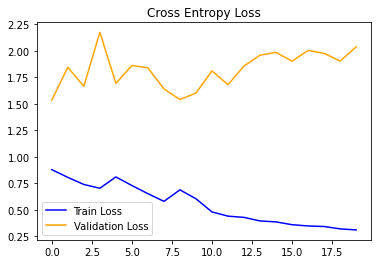

In [170]:
plotLearningCurve(history)